In [34]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sb

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn import metrics

import os

import warnings 
warnings.filterwarnings('ignore')

dirname ='/kaggle/input/diabetes-health-indicators-dataset'
filename= 'diabetes_012_health_indicators_BRFSS2015.csv'
file = os.path.join(dirname, filename)

In [35]:
df = pd.read_csv(file)
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)

print(df.info())
print(df.describe())

print(df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253680 entries, 0 to 253679
Data columns (total 22 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Diabetes_012          253680 non-null  float64
 1   HighBP                253680 non-null  float64
 2   HighChol              253680 non-null  float64
 3   CholCheck             253680 non-null  float64
 4   BMI                   253680 non-null  float64
 5   Smoker                253680 non-null  float64
 6   Stroke                253680 non-null  float64
 7   HeartDiseaseorAttack  253680 non-null  float64
 8   PhysActivity          253680 non-null  float64
 9   Fruits                253680 non-null  float64
 10  Veggies               253680 non-null  float64
 11  HvyAlcoholConsump     253680 non-null  float64
 12  AnyHealthcare         253680 non-null  float64
 13  NoDocbcCost           253680 non-null  float64
 14  GenHlth               253680 non-null  float64
 15  

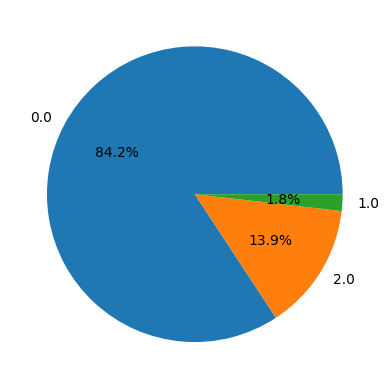

In [36]:
plt.pie(df['Diabetes_012'].value_counts().values,
        labels = df['Diabetes_012'].value_counts().index,
        autopct='%1.1f%%')

plt.show()

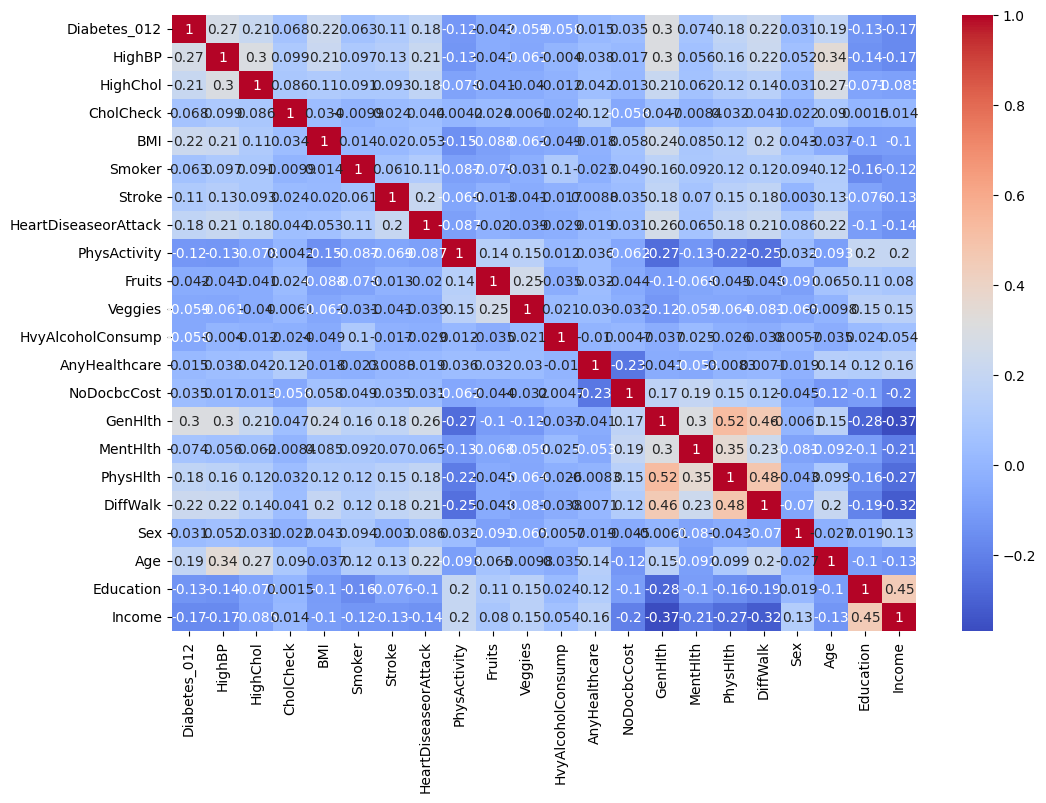

In [37]:
corr_matrix = df.corr()
plt.figure(figsize=(12, 8))
sb.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()

In [38]:
features = df.drop(columns=['Diabetes_012'])

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

continuous_features = ['BMI', 'MentHlth', 'PhysHlth', 'Age', 'GenHlth']

scaler = StandardScaler()

df[continuous_features] = scaler.fit_transform(df[continuous_features])

discrete_features = [
    'Diabetes_012', 'HighBP', 'HighChol', 'CholCheck', 'Smoker', 'Stroke',
    'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies',
    'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'DiffWalk', 'Sex',
    'Education', 'Income'
]

features = continuous_features + discrete_features

kmeans = KMeans(n_clusters=3, random_state=42)
df['Cluster'] = kmeans.fit_predict(df[features])

cluster_centers = pd.DataFrame(kmeans.cluster_centers_, columns=features)
print(cluster_centers)

        BMI  MentHlth  PhysHlth       Age   GenHlth  Diabetes_012    HighBP  \
0  0.014172 -0.171263 -0.289869  0.194830  0.129078      0.371351  0.496570   
1 -0.080724 -0.183966 -0.262312 -0.112258 -0.303395      0.199193  0.362130   
2  0.440607  1.464913  2.192160  0.216314  1.484383      0.700697  0.667625   

   HighChol  CholCheck    Smoker  ...  PhysActivity    Fruits   Veggies  \
0  0.438209   0.956106  0.486629  ...      0.701429  0.606368  0.749389   
1  0.388270   0.963049  0.396115  ...      0.824540  0.659928  0.851847   
2  0.602164   0.975304  0.620318  ...      0.483140  0.547056  0.715113   

   HvyAlcoholConsump  AnyHealthcare  NoDocbcCost  DiffWalk       Sex  \
0           0.042274       0.902477     0.121439  0.195236  0.364920   
1           0.064767       0.973166     0.045036  0.071741  0.481601   
2           0.037530       0.931519     0.229024  0.672047  0.369473   

   Education    Income  
0   4.507273  3.650373  
1   5.362265  7.352141  
2   4.453987  3.89

In [39]:
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)).drop('Diabetes_012')

threshold = 0.2

high_corr_pairs = [(column, row) for column in upper.columns for row in upper.index 
                   if column != row and abs(upper[column][row]) > threshold]

unique_pairs = set()

top_4_pairs = []
for pair in high_corr_pairs:
    correlated_features = [feature for feature, corr in corr_matrix[pair[0]].items() if abs(corr) > threshold]
    correlated_features = [f for f in correlated_features if f != 'Diabetes_012']
    for correlated_feature in correlated_features:
        if (pair[0], correlated_feature) not in unique_pairs and (correlated_feature, pair[0]) not in unique_pairs:
            top_4_pairs.append((pair[0], correlated_feature))
            unique_pairs.add((pair[0], correlated_feature))
        if len(top_4_pairs) == 4:
            break
    if len(top_4_pairs) == 4:
        break

print("Top 4 highly correlated feature pairs with 'Diabetes_012' (excluding pairs containing 'Diabetes_012'):")
for pair in top_4_pairs:
    print(pair)


Top 4 highly correlated feature pairs with 'Diabetes_012' (excluding pairs containing 'Diabetes_012'):
('HighChol', 'HighBP')
('HighChol', 'HighChol')
('HighChol', 'GenHlth')
('HighChol', 'Age')


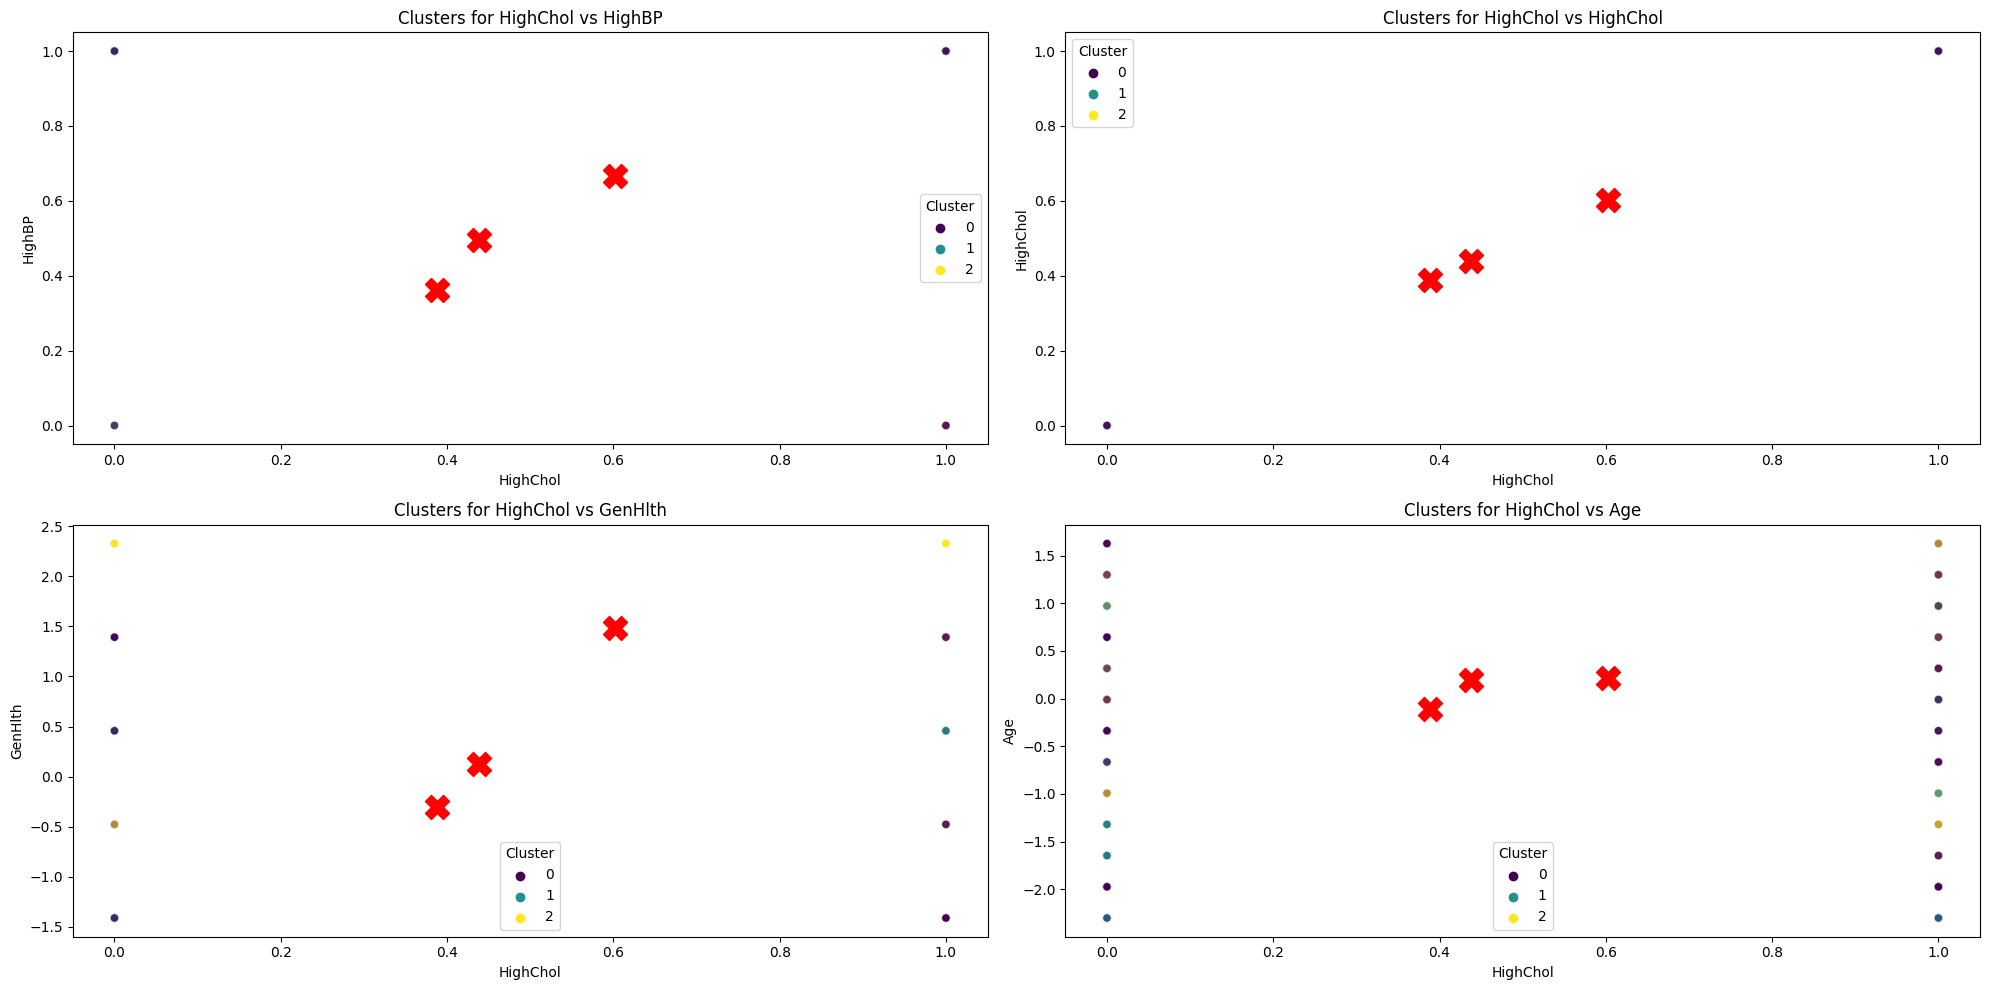

In [40]:
plt.figure(figsize=(20, 10))

for i, (feature_x, feature_y) in enumerate(top_4_pairs, 1): 
    plt.subplot(2, 2, i)
    sb.scatterplot(data=df, x=feature_x, y=feature_y, hue='Cluster', palette='viridis', alpha=0.6)
    plt.scatter(cluster_centers[feature_x], cluster_centers[feature_y], s=300, c='red', marker='X')
    plt.title(f'Clusters for {feature_x} vs {feature_y}')
    plt.xlabel(feature_x)
    plt.ylabel(feature_y)

plt.tight_layout()
plt.show()


In [41]:
personas = []

for i, row in cluster_centers.iterrows():
    persona = {
        'Persona': f'Persona {i+1}',
        'Description': row.to_dict()
    }
    personas.append(persona)

for persona in personas:
    print(persona)


{'Persona': 'Persona 1', 'Description': {'BMI': 0.0141717714858085, 'MentHlth': -0.17126284055664065, 'PhysHlth': -0.28986885093583226, 'Age': 0.19482995724142235, 'GenHlth': 0.1290782250426693, 'Diabetes_012': 0.37135143719231156, 'HighBP': 0.496569795140548, 'HighChol': 0.4382086707956203, 'CholCheck': 0.956106082261391, 'Smoker': 0.486628553279343, 'Stroke': 0.05261235508972591, 'HeartDiseaseorAttack': 0.11246625377163977, 'PhysActivity': 0.7014292520247672, 'Fruits': 0.6063681117992662, 'Veggies': 0.7493885977449721, 'HvyAlcoholConsump': 0.0422740987771969, 'AnyHealthcare': 0.9024773701762643, 'NoDocbcCost': 0.12143878037160649, 'DiffWalk': 0.19523582658409439, 'Sex': 0.3649198030808643, 'Education': 4.507273304748408, 'Income': 3.650373193584655}}
{'Persona': 'Persona 2', 'Description': {'BMI': -0.08072351911008156, 'MentHlth': -0.18396567558929544, 'PhysHlth': -0.2623116558719491, 'Age': -0.1122576184748565, 'GenHlth': -0.3033950433276141, 'Diabetes_012': 0.19919333055040966, 'Hi

In [42]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.neighbors import KNeighborsClassifier

X = df[features]
y = df['Diabetes_012']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train[continuous_features] = scaler.fit_transform(X_train[continuous_features])
X_test[continuous_features] = scaler.transform(X_test[continuous_features])

encoder = OneHotEncoder(drop='first', sparse=False)
X_train_encoded = encoder.fit_transform(X_train[discrete_features])
X_test_encoded = encoder.transform(X_test[discrete_features])

X_train_processed = np.concatenate([X_train[continuous_features].values, X_train_encoded], axis=1)
X_test_processed = np.concatenate([X_test[continuous_features].values, X_test_encoded], axis=1)

knn = KNeighborsClassifier(n_neighbors=5)  # Adjust the number of neighbors as needed
knn.fit(X_train_processed, y_train)

personas_test = knn.predict(X_test_processed)

from sklearn.metrics import classification_report
print(classification_report(y_test, personas_test))



              precision    recall  f1-score   support

         0.0       0.96      1.00      0.98     42795
         1.0       1.00      0.11      0.20       944
         2.0       0.99      0.85      0.92      6997

    accuracy                           0.96     50736
   macro avg       0.98      0.66      0.70     50736
weighted avg       0.96      0.96      0.96     50736

